In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import json
import os
from itertools import product
import warnings


# Problema

Risolveremo un problema giocattolo di classificazione binaria, basato sul _LendingClub Dataset_.

Il modello che alleneremo, dovrà determinare se un individuo sarà in grado di estinguere il prestito in base ai dati collezionati durante l'avvio della pratica. La variabile target sarà, pertanto, __loan_risk__ che assumerà i valori:
- Paid, a indicare che il cliente ha saldato il debito entro i tempi previsti (1)
- Charged off, altrimenti (0)

Vedremo come mlflow può rivelarsi utile in diversi step di una pipeline di produzione:
1) ottimizzeremo i parametri del modello, quindi, terremo traccia dei diversi esperimento
2) salveremo i modelli in un registro
3) metteremo i modelli in produzione, esponendolo attraverso un api

In [ ]:
data = pd.read_csv('./train_dataset.csv')
data_test = pd.read_csv('./test_dataset.csv')

In [ ]:
data.head()

In [ ]:
data['loan_risk'].value_counts()

In [ ]:
data['loan_risk'] = data['loan_risk'].apply(lambda x: 1 if x == 'Paid' else 0)
data_test['loan_risk'] = data_test['loan_risk'].apply(lambda x: 1 if x == 'Paid' else 0)

In [ ]:
data_train, data_val = train_test_split(data, test_size=0.2)

# Pipeline di classificazione

1) I dati da dare in pasto al modello vengono processati e preparati
2) Si allena il modello
3) Si valuta la predizione
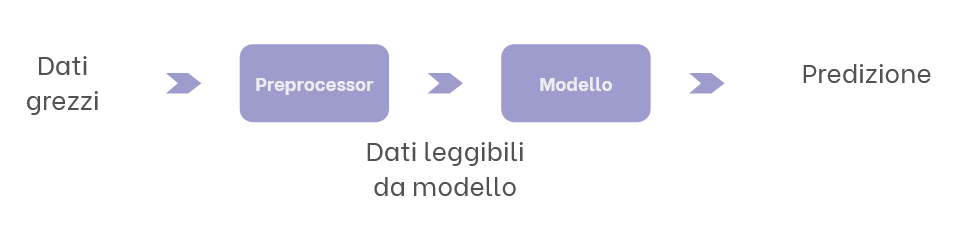

In [ ]:
def train_xgboost_pipeline(data_x, data_y, parameters=None):
    # Questa funzione allena un classificatore xgboost utilizzando gli iperparametri definiti in parameters

    if parameters is None:
        parameters = dict(
            n_estimators=100, 
            max_depth=4, 
            scale_pos_weight=1,
            learning_rate=0.1
        )
    
    # Preprocessamento features numeriche e categoriche

    numerical_features = data_x.select_dtypes(include="number").columns
    categorical_features = data_x.select_dtypes(include="object").columns

    # sostituiamo eventuali valori nulli utilizzando la mediana lungo ogni colonna
    numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

    # codifichiamo le variabili categoriche
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])


    # applichiamo le tasformazioni alle colonne
    preprocessor = ColumnTransformer(
        transformers=[
            ('ord', numerical_transformer, numerical_features), 
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Creazione di una pipeline preprocessor + XGBoost
    
    xgb_clf = XGBClassifier(
        n_estimators=parameters['n_estimators'],
        max_depth=parameters['max_depth'],
        scale_pos_weight=parameters['scale_pos_weight'],
        learning_rate=parameters['learning_rate'],
        random_state=42,
        n_jobs=4
    )

    xgb_pipeline = Pipeline(
        steps=[
            ("preprocessing", preprocessor), 
            ("xgb_model", xgb_clf)
        ]
    )

    # Fit della pipeline

    xgb_pipeline.fit(data_x, data_y)

    return xgb_pipeline

In [ ]:
clf = train_xgboost_pipeline(data_train.drop(['loan_risk'],axis=1), data_train['loan_risk'])

In [ ]:
clf

In [ ]:
from sklearn.metrics import classification_report

report_val = classification_report(data_val['loan_risk'],
                                   clf.predict(data_val.drop(['loan_risk'],axis=1)), 
                                   output_dict=True)

report_test = classification_report(data_test['loan_risk'],
                                    clf.predict(data_test.drop(['loan_risk'],axis=1)), 
                                    output_dict=True)

In [ ]:
report_val

# Grid search


Cerchiamo la combinazione di parametri che restituisce i migliori risulatati sul set di validazione. Quindi, logghiamo ciascun esperimento usando mlflow.

In [ ]:
import mlflow

max_depth = [3, 6]
scale_pos_weight = [0.1, 1, 10]
learning_rate = [0.01, 0.001]
n_estimators = [100, 50]

name_experiment = 'First grid-search'

parameters = product(max_depth, scale_pos_weight, learning_rate, n_estimators)
parameters_list = list(parameters)

print('Number of experiments:', len(parameters_list))

# Hyperparameter search
results = []
best_param = None
best_f1 = 0.0
warnings.filterwarnings('ignore')

for i, param in enumerate(parameters_list):
    print('Running experiment number ', i)
    with mlflow.start_run(run_name=name_experiment):
        # Tell mlflow to log the following parameters for the experiments dashboard
        mlflow.log_param('max_depth', param[0])
        mlflow.log_param('scale_pos_weight', param[1])
        mlflow.log_param('learning_rate', param[2])
        mlflow.log_param('n_estimators', param[3])
        # mlflow.log_param('version', os.system('git describe --all --long'))

        try:
            parameters = dict(n_estimators=param[3], 
                              max_depth=param[0], 
                              scale_pos_weight=param[1],
                              learning_rate=param[2])

            clf = train_xgboost_pipeline(data_train.drop(['loan_risk'],axis=1),
                                         data_train['loan_risk'], 
                                         parameters=parameters)
            
            
            report_val = classification_report(data_val['loan_risk'],
                                               clf.predict(data_val.drop(['loan_risk'],axis=1)), 
                                               output_dict=True)

            report_test = classification_report(data_test['loan_risk'],
                                                clf.predict(data_test.drop(['loan_risk'],axis=1)), 
                                                output_dict=True)

            # Tell mlflow to log the following metrics
            mlflow.log_metric("recall", report_val['0']['recall'])            
            mlflow.log_metric("precision", report_val['0']['precision'])
            mlflow.log_metric("F1", report_val['0']['f1-score'])

            # Store this artifact for each run
            json.dump(report_test, open("metrics.json", "w"))
            mlflow.log_artifact('./metrics.json')

            # save the best experiment yet (in terms of precision)
            if report_val['0']['f1-score'] > best_f1:
                best_param = parameters
                best_f1 = report_val['0']['f1-score']
            
                                            
            results.append([param, report_val['0']['f1-score']])

        except ValueError:
            print('bad parameter combination:', param)
            continue

mlflow.end_run()
print('Best F1 was:', best_f1)
print('Using the following parameters')
print(best_param)

In [ ]:
best_param

# Salvataggio del modello 

Salviamo il modello nel nostro registro

In [ ]:
from mlflow.models.signature import infer_signature

best_clf = train_xgboost_pipeline(data_train.drop(['loan_risk'], axis=1),
                                     data_train['loan_risk'], 
                                     parameters=best_param)

signature = infer_signature(data_val.drop(['loan_risk'], axis=1),
                            best_clf.predict(data_val.drop(['loan_risk'], axis=1)))


input_example = {}
for i in data_val.drop(['loan_risk'],axis=1).columns:
    input_example[i] = data_val[i].iloc[0]

    
mlflow.sklearn.save_model(best_clf, path='./model2/',signature=signature, input_example=input_example)


# per caricare uno dei modelli del registro
# saved_model_path="."
# reloaded_model = mlflow.sklearn.load_model(model_uri=saved_model_path)

In [ ]:
input_example

# Creazione di un'API impacchettata in un container Docker

mlflow offre la possibilita' di mettere in produzione uno dei modelli del nostro registro impacchettandolo in un container docker che espone un'API per fare query del modello.


Per creare l'immagine docker possiamo usare il comando
```
mlflow models build-docker -m "./best_model" -n "xgboost_loan"     
```


Una volta che l'immagine e' stata creata possiamo fare partire il container con
```
docker run -p 5001:8080 xgboost_loan                                    
```                                        

# Query del modello

Prendiamo un esempio di input salvato e creiamo un payload per l'API

In [ ]:
import requests
import json


with open('./model2/input_example.json') as f:
    sample_input = json.load(f)
sample_input['data'][0][0]=1000
print(sample_input)

In [ ]:
response = requests.post(
              url='http://127.0.0.1:5001/invocations', data=json.dumps(sample_input),
              headers={"Content-type": "application/json"})
response_json = json.loads(response.text)
print('Predicted loan outcome: '+response_json[0])